The storage operation is plotted for yearly optimization (2019) of the energy arbitrage value. The optimization is made with 2 weeks planning horizon and 12 hours of storage. Correlation between net energy discharged by the storage system and the price of electricity is compared for energy efficiency = 100% and 60%. 

In [2]:
##############################
## IMPORT AND PREPARE DATA ##
############################
import numpy as np
import pandas as pd
import itertools
from datetime import datetime
from typing import List
from pyomo.environ import *

start_time = datetime.now()

# Import data
filename = 'HOEP_2015-2019_dataset.csv'
data = pd.read_csv(filename)
cols_of_interest = ["Date", "Hour", "OntDem", "HOEP", "Weekday"]
data = data[cols_of_interest]

# Create different datasets for each year
df_2015 = data.loc[:8759]
df_2016 = data.loc[8760:17543]
df_2017 = data.loc[17544:26303]
df_2018 = data.loc[26304:35063]
df_2019 = data.loc[35064:]

dataframe = df_2019.copy()  # choose the year of data we want to optimize for
dataframe = dataframe.reset_index(drop=True)

# Definition of the hours of storage range values we will create
hours = np.arange(1,49,1)

# Define a list of possible horizon preriod to test and choose the appropriate one
list_horizons = ["1d","7d", "14d"]
horizon = list_horizons[2]
df_2019

,Date,Hour,OntDem,HOEP,Weekday
35064,2019-01-01,1,13198,0.00,1
35065,2019-01-01,2,12737,0.00,1
35066,2019-01-01,3,12531,-0.11,1
35067,2019-01-01,4,12291,-1.84,1
35068,2019-01-01,5,12305,-0.47,1


In [3]:
#########################################################################
### Computing Arbitrage value optimization for hours of storage = 12 ###
#######################################################################
start_time = datetime.now()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')
df = dataframe.copy()

grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
Profits = [] # create empty lists and store results in it during the loop
list_Date = []
list_HOEP = []
list_OntDem = []
list_Z = []
list_Ein = []
list_Eout = []
list_NES = []
list_L = []
list_weekday = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.NES = Var(model.T)
    eta = 1

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == dataframe.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def demand_constraint(model, t):
        return (model.L[t] == (group.loc[t, 'OntDem'] + (model.Ein[t]) - (model.Eout[t]))) 
    model.demand_constraint = Constraint(model.T, rule=demand_constraint)
    
    def Net_energy_sold(model, t):
        return model.NES[t] == ((model.Eout[t] - model.Ein[t]) / model.Rmax * 100)                       
    model.net_energy = Constraint(model.T, rule=Net_energy_sold)

    # Objective function and optimization
    income = sum(group.loc[t,'HOEP'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 

    # Extract model output in list
    Date = (list(group['Datetime']))
    weekday = list(group['Weekday'])
    HOEP = list(group['HOEP'])
    OntDem = list(group['OntDem'])
    Z = list(model.Z.get_values().values())
    Ein= list(model.Ein.get_values().values())
    Eout = list(model.Eout.get_values().values())
    NES = list(model.NES.get_values().values())
    L = list(model.L.get_values().values())
    SOC = list(model.Z.get_values().values())[-1]
    
    Profits.append(model.objective())
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_OntDem.append(OntDem)
    list_Z.append(Z)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_NES.append(NES)
    list_L.append(L)
    list_weekday.append(weekday)

# Present final results in a dataframe
results = pd.DataFrame(list(itertools.chain(*list_Date)), columns=['Datetime'])
results['Weekday'] = list(itertools.chain(*list_weekday))
results['HOEP'] = list(itertools.chain(*list_HOEP))
results['Ein'] = list(itertools.chain(*list_Ein))
results['Eout'] = list(itertools.chain(*list_Eout))
results['SOC'] = list(itertools.chain(*list_Z))
results['NES'] = list(itertools.chain(*list_NES))
results_100 = results.round(2)

storage_HOEP_2019 = sum(Profits)/1000
print("Storage value with perfect foresight and 12h storage:", storage_HOEP_2019)
print("Running time:", datetime.now() - start_time)
results_100.head()

Storage value with perfect foresight and 12h storage: 66.69857685180666
Running time: 0:00:08.596825


,Datetime,Weekday,HOEP,Ein,Eout,SOC,NES
0,2019-01-01 01:00:00,1,0.00,0.0,0.0,6.0,0.0
1,2019-01-01 02:00:00,1,0.00,0.0,1.0,5.0,100.0
2,2019-01-01 03:00:00,1,-0.11,1.0,0.0,6.0,-100.0
3,2019-01-01 04:00:00,1,-1.84,1.0,0.0,7.0,-100.0
4,2019-01-01 05:00:00,1,-0.47,1.0,0.0,8.0,-100.0


<ipython-input-21-fdfbb5ad4559>:20: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  fig.legend(('HOEP', 'Énergie nette utilisée'), loc='best')


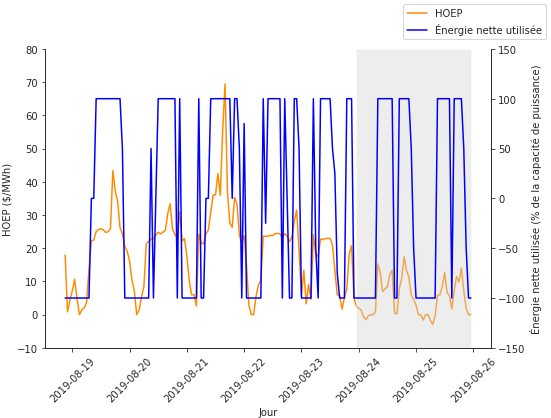

In [21]:
## Select subset of results and visualize net energy sold ##
###########################################################
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Choose subset of data to show
df_subset = results_100.loc[5516:5686]  # choose part of data to illustrate it

with sns.axes_style("ticks", {"grid.color": "white"}):
    ax1 = sns.set_style(style=None, rc=None )
    fig, ax1 = plt.subplots(figsize=(8,5.5))
    sns.lineplot(data=df_subset,x='Datetime', y='HOEP',color="darkorange",legend='full',ax=ax1,zorder=10)
    plt.ylabel("HOEP ($/MWh)")
    plt.xlabel('Jour')
    plt.xticks(rotation=45)
    ax1.set_ylim(-10, 80)
    ax2 = ax1.twinx()
    sns.lineplot(data=df_subset,x='Datetime', y='NES', color="blue",legend='full',ax=ax2,zorder=5)
    fig.legend(('HOEP', 'Énergie nette utilisée'), loc='best')
    ax2.set_ylim(-150, 150)
    plt.ylabel('Énergie nette utilisée (% de la capacité de puissance)')
    plt.axvspan(df_subset.Datetime.loc[5638], df_subset.Datetime.loc[5686], facecolor='lightgrey',
                alpha=0.4, zorder=1)
    sns.despine(top=True, right=False)
    #plt.savefig('Charging_process_Battery2019_FR', dpi=1200, bbox_inches='tight')

In [ ]:
#########################################################################
### Computing Arbitrage value optimization for hours of storage = 12 ###
#######################################################################
start_time = datetime.now()

# Créer un DatetimeIndex pour pouvoir utiliser df.groupby et pd.Grouper ensuite
dataframe['Datetime'] = pd.to_datetime(dataframe.Date) + pd.to_timedelta(dataframe.Hour, unit='h')
df = dataframe.copy()

grouped = df.set_index('Datetime').groupby(pd.Grouper(freq=horizon))

duration = 12
Profits = [] # create empty lists and store results in it during the loop
list_Date = []
list_HOEP = []
list_OntDem = []
list_Z = []
list_Ein = []
list_Eout = []
list_NES = []
list_L = []
list_weekday = []

for name, group in grouped:
    group.reset_index(inplace=True)

    model = ConcreteModel()
    
    # Variables of the model
    model.T = Set(initialize=group.index, ordered=True)
    model.Rmax = Param(initialize=1, within=Any) 
    model.Smax = Param(initialize=duration, within=Any)
    model.Dmax = Param(initialize=duration, within=Any) 
    model.Ein = Var(model.T, domain=NonNegativeReals)  
    model.Eout = Var(model.T, domain=NonNegativeReals) 
    model.Z = Var(model.T, domain=NonNegativeReals)  
    model.L = Var(model.T, domain=NonNegativeReals) 
    model.NES = Var(model.T)
    eta = 0.6

    # Constraints
    def storage_state(model, t):
        if group['Datetime'].iloc[0] == dataframe.Datetime[0]:  
            if t == model.T.first():
                return model.Z[t] == duration/2 
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*eta - model.Eout[t]
        else:
            if t == model.T.first():
                return model.Z[t] == SOC + model.Ein[t]*eta - model.Eout[t]
            else:
                return model.Z[t] == model.Z[t-1] + model.Ein[t]*eta - model.Eout[t]
    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        return model.Eout[t] <= model.Rmax
    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        return model.Ein[t] <= model.Rmax
    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t): 
        return model.Eout[t] <= model.Z[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def max_SOC(model, t): 
        return model.Z[t] <= model.Smax
    model.max_SOC = Constraint(model.T, rule=max_SOC)
        
    def demand_constraint(model, t):
        return (model.L[t] == (group.loc[t, 'OntDem'] + (model.Ein[t]) - (model.Eout[t]))) 
    model.demand_constraint = Constraint(model.T, rule=demand_constraint)
    
    def Net_energy_sold(model, t):
        return model.NES[t] == ((model.Eout[t] - model.Ein[t]) / model.Rmax * 100)                       
    model.net_energy = Constraint(model.T, rule=Net_energy_sold)

    # Objective function and optimization
    income = sum(group.loc[t,'HOEP'] * model.Eout[t] for t in model.T)
    expenses = sum(group.loc[t,'HOEP'] * model.Ein[t] for t in model.T)
    profits = (income - expenses) 
    model.objective = Objective(expr=profits, sense=maximize)

    # Solve model
    solver = SolverFactory('glpk')
    solver.solve(model) 

    # Extract model output in list
    Date = (list(group['Datetime']))
    weekday = list(group['Weekday'])
    HOEP = list(group['HOEP'])
    OntDem = list(group['OntDem'])
    Z = list(model.Z.get_values().values())
    Ein= list(model.Ein.get_values().values())
    Eout = list(model.Eout.get_values().values())
    NES = list(model.NES.get_values().values())
    L = list(model.L.get_values().values())
    SOC = list(model.Z.get_values().values())[-1]
    
    Profits.append(model.objective())
    list_Date.append(Date)
    list_HOEP.append(HOEP)
    list_OntDem.append(OntDem)
    list_Z.append(Z)
    list_Ein.append(Ein)
    list_Eout.append(Eout)
    list_NES.append(NES)
    list_L.append(L)
    list_weekday.append(weekday)

# Present final results in a dataframe
results = pd.DataFrame(list(itertools.chain(*list_Date)), columns=['Datetime'])
results['Weekday'] = list(itertools.chain(*list_weekday))
results['HOEP'] = list(itertools.chain(*list_HOEP))
results['Ein'] = list(itertools.chain(*list_Ein))
results['Eout'] = list(itertools.chain(*list_Eout))
results['SOC'] = list(itertools.chain(*list_Z))
results['NES'] = list(itertools.chain(*list_NES))
results_60 = results.round(2)

storage_HOEP_2019 = sum(Profits)/1000
print("Storage value with perfect foresight and 12h storage:", storage_HOEP_2019)
print("Running time:", datetime.now() - start_time)
results_60.head()

Pearsons correlation with eta 60%: 0.4360769847308074
Pearsons correlation with eta = 100%: 0.33978768927327685


,Weekday,HOEP,Ein,Eout,SOC,NES
Weekday,1.000000,-0.058043,0.086478,-0.016169,-0.060191,-0.064183
HOEP,-0.058043,1.000000,-0.429728,0.296983,-0.054134,0.436077
Ein,0.086478,-0.429728,1.000000,-0.427856,0.118909,-0.872438
Eout,-0.016169,0.296983,-0.427856,1.000000,-0.039485,0.815011
SOC,-0.060191,-0.054134,0.118909,-0.039485,1.000000,-0.097581
NES,-0.064183,0.436077,-0.872438,0.815011,-0.097581,1.000000


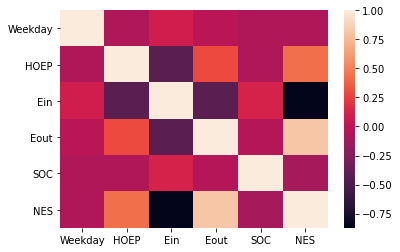

In [18]:
# Correlation between charge and NES
from scipy.stats import pearsonr

# calculate Pearson's correlation
corr_p_60, _ = pearsonr(results_60.HOEP, results_60.NES)
print('Pearsons correlation with eta 60%:', corr_p_60)

corr_p_100, _ = pearsonr(results_100.HOEP, results_100.NES)
print('Pearsons correlation with eta = 100%:', corr_p_100)

corr = results.corr()
sns.heatmap(corr)
corr